In [1]:
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import layers, models
from keras.utils import load_img, img_to_array
from matplotlib import pyplot as plt
import os
import re
import pandas as pd
from collections import defaultdict
import matplotlib.colors as mcolors

# --- COLOR SPACE UTILITIES ---
def hex_to_rgb(hex_color):
    return [int(hex_color[i:i+2], 16)/255.0 for i in (0, 2, 4)]

def f(t):
    delta = 6/29
    return np.where(t > delta**3, np.cbrt(t), (t / (3 * delta**2)) + (4/29))

def inv_f(t):
    delta = 6/29
    return np.where(t > delta, t**3, 3 * delta**2 * (t - 4/29))

def inv_gamma_correct(c):
    return np.where(c <= 0.0031308, 12.92 * c, 1.055 * np.power(c, 1/2.4) - 0.055)

def lab_normalize(lab):
    return (lab + np.array([0, 128, 128])) / np.array([100, 255, 255])

def lab_unnorm(lab):
    return lab * np.array([100, 255, 255]) - np.array([0, 128, 128])

def lab_to_rgb(lab):
    L, a, b = lab
    fy = (L + 16) / 116
    fx = fy + a / 500
    fz = fy - b / 200
    xyz = np.array([
        0.95047 * inv_f(fx),
        1.00000 * inv_f(fy),
        1.08883 * inv_f(fz)
    ])
    rgb_lin = np.array([
        3.2406 * xyz[0] - 1.5372 * xyz[1] - 0.4986 * xyz[2],
        -0.9689 * xyz[0] + 1.8758 * xyz[1] + 0.0415 * xyz[2],
        0.0557 * xyz[0] - 0.2040 * xyz[1] + 1.0570 * xyz[2]
    ])
    rgb = inv_gamma_correct(np.clip(rgb_lin, 0, 1))
    return np.clip(rgb, 0, 1)

def rgb_to_hex(rgb):
    return '#{:02x}{:02x}{:02x}'.format(int(rgb[0]*255), int(rgb[1]*255), int(rgb[2]*255))

def convert_lab(image):
    mask = image > 0.04045
    img_linear = np.where(mask, ((image + 0.055) / 1.055) ** 2.4, image / 12.92)
    R, G, B = img_linear[..., 0], img_linear[..., 1], img_linear[..., 2]
    X = (0.4124564 * R + 0.3575761 * G + 0.1804375 * B) / 0.950489
    Y = (0.2126729 * R + 0.7151522 * G + 0.0721750 * B) / 1.0
    Z = (0.0193339 * R + 0.1191920 * G + 0.9503041 * B) / 1.088840
    X, Y, Z = f(X), f(Y), f(Z)
    L = 116.0 * Y - 16.0
    a = 500.0 * (X - Y)
    b = 200.0 * (Y - Z)
    return np.stack([L, a, b], axis=-1)

def make_dataset():
    basedir = "Data/Res_ColorPickerCustomPicker"
    rows = []

    for file in os.listdir(basedir):
        filepath = os.path.join(basedir, file)
        if re.match(r".*\d{2}\.txt", file):
            image_groups = defaultdict(list)  # key: image filename, value: list of color groups

            with open(filepath, "r") as f:
                for line in f:
                    parts = line.strip().split()
                    if not parts:
                        continue
                    image = parts[0]
                    colors = [c.strip(",").replace('#', '') for c in parts[1:]]
                    image_groups[image].append(colors)

            # Now for each image in this file, pad its color groups and add to the rows
            for image, color_groups in image_groups.items():
                while len(color_groups) < 5:
                    color_groups.append([])

                rows.append({
                    'file': file,
                    'image': image,
                    'color_1': color_groups[0],
                    'color_2': color_groups[1],
                    'color_3': color_groups[2],
                    'color_4': color_groups[3],
                    'color_5': color_groups[4],
                })

    return pd.DataFrame(rows)



def hex_to_rgb_tuple(hex_color):
    return mcolors.to_rgb(hex_color)

2025-06-18 18:29:47.270761: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-18 18:29:47.273485: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-18 18:29:47.280460: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750264187.292260   89214 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750264187.295709   89214 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750264187.307327   89214 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [ ]:
import numpy as np
# Test Lab conversion
rgb_color = np.array([0.5, 0.2, 0.8]) # Example RGB color
lab_color = convert_lab(rgb_color)
print(f"RGB: {rgb_color}")
print(f"Lab: {lab_color}")

# Convert back to RGB to check
rgb_back = lab_to_rgb(lab_color)
print(f"RGB back from Lab: {rgb_back}")

# Test normalization and unnormalization
normalized_lab = lab_normalize(lab_color)
print(f"Normalized Lab: {normalized_lab}")

unnormalized_lab = lab_unnorm(normalized_lab)
print(f"Unnormalized Lab: {unnormalized_lab}")

# Test with hex
hex_color = "ff0000" # Red
rgb_from_hex = hex_to_rgb(hex_color)
print(f"Hex: {hex_color}, RGB from hex: {rgb_from_hex}")

# Test hex to rgb tuple
rgb_tuple_from_hex = hex_to_rgb_tuple("#"+hex_color)
print(f"Hex: {hex_color}, RGB tuple from hex: {rgb_tuple_from_hex}")

# Test rgb to hex
hex_from_rgb = rgb_to_hex(rgb_from_hex)
print(f"RGB: {rgb_from_hex}, Hex from RGB: {hex_from_rgb}")

In [2]:
# --- DATA PREPARATION ---
# Load and process your dataframe
input_colors = 5
basedir = "Data/PhotosColorPicker/"

df = make_dataset()
df['image_path'] = basedir + df['image']

def load_image(path):
    img = load_img(path, target_size=(128, 128))
    rgb_norm = img_to_array(img) / 255.0
    lab = convert_lab(rgb_norm)
    return lab_normalize(lab)

b = df.groupby(df['image']).sum()
b = b[['color_1','color_2','color_3','color_4','color_5']]
b = b.reset_index()
b['image_path'] = basedir + b['image']
from sklearn.cluster import KMeans

for c in range(1,6):
    b[f"norm_rgb_{c}"] = b[f'color_{c}'].apply(lambda a : [hex_to_rgb(str(i)) for i in a])
for c in range(1,6):
    b[f"lab_{c}"] = b[f'norm_rgb_{c}'].apply(lambda a : [convert_lab(np.array(i)) for i in a])

for c in range(1,6):
    b[f"norm_lab_{c}"] = b[f'lab_{c}'].apply(lambda a : [lab_normalize(np.array(i)) for i in a])

def cluster_image_colors(color_vectors, n_clusters=5):
    # Convert to numpy array
    color_array = np.array(color_vectors)

    # Handle edge cases: if fewer vectors than clusters
    if len(color_array) < n_clusters:
        return color_array  # Just return raw vectors

    # Apply KMeans
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(color_array)

    return kmeans.cluster_centers_

# Apply to each row (each image)
b['color_palette_lab'] = b[f'norm_lab_{input_colors}'].apply(lambda x: cluster_image_colors(x, n_clusters=input_colors))
b["color_paletter_rgb"] = b['color_palette_lab'].apply(
    lambda palette: [lab_to_rgb(lab_unnorm(color)) for color in palette]
)
c = b["color_paletter_rgb"]

image_tensors = tf.stack([load_image(path) for path in b['image_path']])
labs = np.stack(b['color_palette_lab'].values)
labels = np.array(labs.astype(np.float64)).reshape(-1, 3*input_colors)
# TF dataset
dataset = tf.data.Dataset.from_tensor_slices((image_tensors, labels)).shuffle(buffer_size=len(image_tensors))
val_size = int(0.2 * len(image_tensors))
train_dataset = dataset.skip(val_size).batch(32)
val_dataset = dataset.take(val_size).batch(32)

2025-06-18 18:30:02.626297: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [ ]:
a = make_dataset()
b = a.groupby(a['image']).sum()
b = b[['color_1','color_2','color_3','color_4','color_5']]

from sklearn.cluster import KMeans

clusters = 5

for c in range(1,6):
    b[f"norm_rgb_{c}"] = b[f'color_{c}'].apply(lambda a : [hex_to_rgb(str(i)) for i in a])
for c in range(1,6):
    b[f"lab_{c}"] = b[f'norm_rgb_{c}'].apply(lambda a : [convert_lab(np.array(i)) for i in a])

for c in range(1,6):
    b[f"norm_lab_{c}"] = b[f'lab_{c}'].apply(lambda a : [lab_normalize(np.array(i)) for i in a])

def cluster_image_colors(color_vectors, n_clusters=5):
    # Convert to numpy array
    color_array = np.array(color_vectors)

    # Handle edge cases: if fewer vectors than clusters
    if len(color_array) < n_clusters:
        return color_array  # Just return raw vectors

    # Apply KMeans
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(color_array)

    return kmeans.cluster_centers_

# Apply to each row (each image)
b['color_palette_lab'] = b[f'norm_lab_{clusters}'].apply(lambda x: cluster_image_colors(x, n_clusters=clusters))
b["color_paletter_rgb"] = b['color_palette_lab'].apply(
    lambda palette: [lab_to_rgb(lab_unnorm(color)) for color in palette]
)
c = b["color_paletter_rgb"]
print(b['color_palette_lab'])

In [3]:
# --- MODEL DEFINITION ---
# model = models.Sequential([
#     layers.Input(shape=(64, 64, 3)),
#     layers.Conv2D(32, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Flatten(),
#     layers.Dense(256, activation='relu'),
#     layers.Dense(3*input_colors, activation='sigmoid')
# ])

# model = models.Sequential([
#     layers.Input(shape=(64, 64, 3)),
#     layers.Conv2D(32, (7, 7), activation='relu'),
#     layers.MaxPooling2D(2, 2),
#     layers.Conv2D(64, (3, 3), activation='relu'),
#     layers.MaxPooling2D(4, 4),
#     layers.Flatten(),
#     layers.Dense(3*256, activation='relu'),
#     layers.Dropout(0.3),
#     layers.Dense(3*input_colors, activation='sigmoid')  # Predict L, a, b
# ])
#
# model = models.Sequential([
#     layers.Input(shape=(64, 64, 3)),
#     layers.Conv2D(16 * input_colors, (3, 3), activation='relu'),
#     layers.MaxPooling2D(2, 2),
#
#     layers.Conv2D(32 * input_colors, (3, 3), activation='relu'),
#     layers.MaxPooling2D(2, 2),
#
#     layers.Conv2D(64 * input_colors, (3, 3), activation='relu'),
#     layers.Flatten(),
#     layers.Dropout(0.5),
#     layers.Dense(3 * input_colors, activation='sigmoid')
# ])


model = models.Sequential([
    layers.Input(shape=(128, 128, 3)),
    layers.Conv2D(16 * input_colors, (3, 3), activation='relu'),
    layers.AveragePooling2D(2, 2),

    layers.Conv2D(32 * input_colors, (3, 3), activation='relu'),
    layers.AveragePooling2D(2, 2),

    layers.Conv2D(64 * input_colors, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(3 * input_colors, activation='sigmoid')
])

#!

model.compile(optimizer=tf.keras.optimizers.Adam(amsgrad=True, learning_rate=1e-3), loss='mse')
model.fit(train_dataset, epochs=100, validation_data=val_dataset)


Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 387ms/step - loss: 0.0966 - val_loss: 0.0394
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 357ms/step - loss: 0.0373 - val_loss: 0.0419
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 342ms/step - loss: 0.0382 - val_loss: 0.0382
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 339ms/step - loss: 0.0362 - val_loss: 0.0349
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 348ms/step - loss: 0.0328 - val_loss: 0.0316
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 335ms/step - loss: 0.0331 - val_loss: 0.0314
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 343ms/step - loss: 0.0309 - val_loss: 0.0268
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 338ms/step - loss: 0.0322 - val_loss: 0.0301
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 341ms/step - loss: 0.0310 - val_loss: 0.0278
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 342ms/step - loss: 0.0304 - val_loss: 0.0292
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 347ms/step - loss: 0.0293 - val_loss: 0.0272
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 343ms/step - loss: 0.0

In [4]:
# --- EVALUATION ---
from colormath.color_objects import LabColor
from colormath.color_diff import delta_e_cmc

def mae(predictions, truth):
    return np.mean(np.abs(predictions - truth))

def rmse(predictions, truth):
    return np.sqrt(np.mean((predictions - truth)**2))

def safe_compare(predictions, truth):
    eps = 1e-6
    return np.mean(np.abs(predictions - truth) / (np.abs(truth) + eps), axis=0)

all_preds = model.predict(tf.data.Dataset.from_tensor_slices(image_tensors).batch(32))
val_predicts = model.predict(val_dataset)
print("Compare %:", safe_compare(val_predicts, labels[:len(val_predicts)]) * 100)
print("MAE:", mae(val_predicts, labels[:len(val_predicts)]))
print("RMSE:", rmse(val_predicts, labels[:len(val_predicts)]))


for i in range(5):
    p = (((val_predicts[i])))
    t = ((labels[i]))
    print("Predicted:", rgb_to_hex(p), "True:", rgb_to_hex(t))
# --- PREDICTION VISUALIZATION ---


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
Compare %: [ 52.93244991  22.50814228  32.52095268 175.19839426  17.67816784
  59.44566519 139.33933619  24.10274764  17.6882804  330.54484584
  22.58517992  35.23137443 109.75336908  18.62607945  17.81693419]
MAE: 0.1893019629664349
RMSE: 0.2643755979878178
Predicted: #c18685 True: #ea6bce
Predicted: #c27cbf True: #79b9a0
Predicted: #947794 True: #cf58ad
Predicted: #ea8983 True: #72bda4
Predicted: #6eba3a True: #ef7d81


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted color: ['#77356e', '#cdde9a', '#9b641c', '#ad6d58', '#bca5a2']
True color: ['#07090d', '#abb5b1', '#464b41', '#eaeae9', '#777f7d']


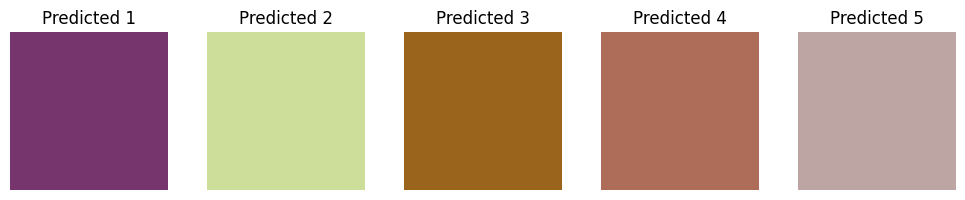

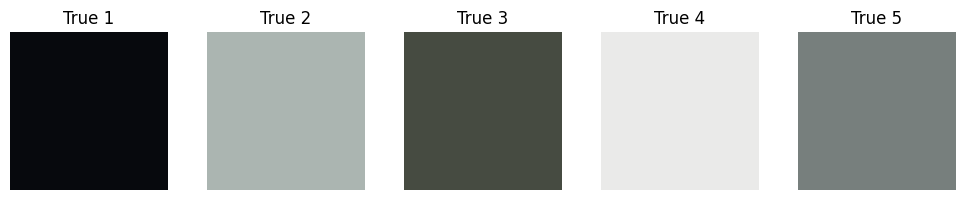

In [10]:
# Predict on new image
#model = keras.saving.load_model("model.keras")
def show_colors(hex_list, titles=None):
    fig, ax = plt.subplots(1, len(hex_list), figsize=(len(hex_list) * 2, 2))
    if len(hex_list) == 1:
        ax = [ax]
    for i, hex_color in enumerate(hex_list):
        rgb = np.array([[hex_to_rgb_tuple(hex_color)]])
        ax[i].imshow(rgb)
        ax[i].axis("off")
        if titles:
            ax[i].set_title(titles[i])
    plt.tight_layout()
    plt.show()
file = "000000461404.jpg"
image_path = f"Data/PhotosColorPicker/{file}"

image = load_img(image_path, target_size=(128, 128))
img_array = img_to_array(image) / 255.0
lab_image = convert_lab(img_array)
lab_normed = lab_normalize(lab_image)
input_arr = np.expand_dims(lab_normed, axis=0)
prediction = model.predict(input_arr).reshape(input_colors,3)
lab_pred = [lab_unnorm(i) for i in prediction]
rgb_pred = [lab_to_rgb(i) for i in lab_pred]
pred_hex = [rgb_to_hex(i) for i in rgb_pred]

true_rgb = [i for i in b[b['image'] == file]["color_paletter_rgb"].iloc[0]]
true_hex = [rgb_to_hex(i) for i in true_rgb]
print("Predicted color:", pred_hex)
print("True color:", true_hex)
titles = [f"Predicted {i+1}" for i in range(len(pred_hex))]
show_colors(pred_hex, titles)
titles = [f"True {i+1}" for i in range(len(true_hex))]
show_colors(true_hex, titles)

In [ ]:
# model.compile(optimizer=tf.keras.optimizers.Adam(amsgrad=True, learning_rate=1e-3), loss='mse')
# model = keras.saving.load_model("model.keras")
model.fit(train_dataset, epochs=10, validation_data=val_dataset)

In [ ]:
model.save("avg.keras")